In [ ]:
def benchmark_translation(n_ctx_value, queries, metadata_lookup, batch_size=20, output_file=None):
    from llama_cpp import Llama
    import time

    llm = Llama(
        model_path="/Users/pierr/Desktop/mistral-7b-instruct-v0.1.Q4_K_M.gguf",
        n_ctx=n_ctx_value
    )

    def translate_query(query, metadata_lookup):
        # Dynamically add metadata descriptions for each field used in the query
        query_fields = [field.strip("[]") for field in query.split() if field.startswith("[") and field.endswith("]")]
        
        # Ensure that metadata descriptions exist for each field used in the query
        metadata_descriptions = [metadata_lookup.get(field, f"No metadata found for {field}") for field in query_fields]

        # Combine metadata descriptions into one string
        metadata = "\n".join(metadata_descriptions)

        # Formulate the prompt using query and the gathered metadata
        prompt = f"Translate the following ESGish query into a natural English sentence:\n\nQuery: {query}\n\nMetadata: {metadata}\n\n### Response:"

        # Truncate query and metadata if needed to fit within token limits
        prompt_tokens = llm.tokenize(prompt.encode("utf-8"))
        prompt_token_count = len(prompt_tokens)

        # Calculate how many tokens are available for the response
        max_response_tokens = n_ctx_value - prompt_token_count
        if max_response_tokens <= 0:
            raise ValueError(f"Prompt too long for context size {n_ctx_value}. Try increasing n_ctx or shortening input.")
        
        # # If the prompt exceeds n_ctx, truncate the query or metadata (whichever is larger)
        # if prompt_token_count > n_ctx_value:
        #     # First, try truncating the query
        #     available_tokens_for_query = n_ctx_value - len(llm.tokenize(f"Query: {metadata}".encode("utf-8"))) - 50  # leave 50 tokens for response
        #     query_tokens = llm.tokenize(query.encode("utf-8"))
        #     query_tokens = query_tokens[:available_tokens_for_query]  # Truncate the query if necessary
        #     query = llm.detokenize(query_tokens).decode("utf-8", errors="ignore")
            
        #     # Regenerate the prompt after truncation
        #     prompt = f"Translate the following ESGish query into a natural English sentence:\n\nQuery: {query}\n\nMetadata: {metadata}\n\n### Response:"

        #     # Check again if we still exceed the context size and truncate metadata if necessary
        #     prompt_tokens = llm.tokenize(prompt.encode("utf-8"))
        #     prompt_token_count = len(prompt_tokens)

        if prompt_token_count > n_ctx_value:
            available_tokens_for_metadata = n_ctx_value - len(llm.tokenize(f"Query: {query}".encode("utf-8"))) - 50
            metadata_tokens = llm.tokenize(metadata.encode("utf-8"))
            metadata_tokens = metadata_tokens[:available_tokens_for_metadata]  # Truncate the metadata if necessary
            metadata = llm.detokenize(metadata_tokens).decode("utf-8", errors="ignore")
            # Regenerate the final prompt with truncated metadata
            prompt = f"Translate the following ESGish query into a natural English sentence:\n\nQuery: {query}\n\nMetadata: {metadata}\n\n### Response:"

        # Now send the truncated (or non-truncated) prompt to the model
        response = llm(prompt, max_tokens=max_response_tokens, temperature=0.1)
        return response["choices"][0]["text"].strip()

    translated_all = []
    start = time.time()

    # Loop through each query and process the translation in batches
    for i in range(0, len(queries), batch_size):
        batch = queries[i:i + batch_size]
        
        # For each query in the batch, get the translation using the metadata lookup
        translated_batch = [translate_query(query, metadata_lookup) for query in batch]
        translated_all.extend(translated_batch)

    end = time.time()
    duration = end - start
    avg_time = duration / len(queries)

    return {
        "n_ctx": n_ctx_value,
        "total_time_sec": duration,
        "avg_time_per_query_sec": avg_time,
        "num_queries": len(queries)
    }


In [ ]:
import pandas as pd
import json

# Assuming the file is named 'metadata.json'
with open('metadata.json', 'r') as f:
    raw_metadata = json.load(f)

metadata_lookup = {
    entry["code"]: f'{entry["name"]}. {entry["description"]}' 
    for entry in raw_metadata
}

results = []
context_sizes = [1024, 2048, 3072, 4096]

df = pd.read_csv("res_len_from_1000_to_1500_len(10).csv")
queries = df["query_text"].tolist()

for ctx in context_sizes:
    result = benchmark_translation(ctx, queries, metadata_lookup)
    results.append(result)


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

df_results = pd.DataFrame(results)

plt.figure(figsize=(10, 6))
plt.plot(df_results["n_ctx"], df_results["avg_time_per_query_sec"], marker='o')
plt.title("LLM Performance vs Context Size")
plt.xlabel("Context Size (n_ctx)")
plt.ylabel("Avg Time per Query (sec)")
plt.grid(True)
plt.show()


-----------------------------**Benchmark at different query lengths**--------

In [9]:
import pandas as pd
import json

# Load metadata
with open('metadata.json', 'r') as f:
    raw_metadata = json.load(f)
metadata_lookup = {
    entry["code"]: f'{entry["name"]}. {entry["description"]}' 
    for entry in raw_metadata
}

# Load queries grouped by length
query_groups = {
    "200-400": pd.read_csv("res_len_from_200_to_400_len(10).csv")["query_text"].tolist(),
    "600-800": pd.read_csv("res_len_from_600_to_800_len(10).csv")["query_text"].tolist(),
    "800-1000": pd.read_csv("res_len_from_800_to_1000_len(10).csv")["query_text"].tolist(),
    "1000-1200": pd.read_csv("res_len_from_1000_to_1200_len(10).csv")["query_text"].tolist()
}

In [10]:
def benchmark_translation(n_ctx, queries, metadata_lookup, batch_size=20):
    from llama_cpp import Llama
    import time

    llm = Llama(
        model_path="/Users/pierr/Desktop/mistral-7b-instruct-v0.1.Q4_K_M.gguf",
        n_ctx=n_ctx
    )

    def translate_query(query):
        # Extract fields like [FIELD] from query
        query_fields = [field.strip("[]") for field in query.split() 
                       if field.startswith("[") and field.endswith("]")]
        metadata = "\n".join(
            metadata_lookup.get(field, f"No metadata for {field}") 
            for field in query_fields
        )

        # Base prompt without metadata
        base_prompt = f"Translate this ESGish query to English:\nQuery: {query}\n### Response:"
        base_prompt_tokens = len(llm.tokenize(base_prompt.encode("utf-8")))
        
        # Calculate available space for metadata
        max_metadata_tokens = n_ctx - base_prompt_tokens - 10  # Leave room for response
        
        if max_metadata_tokens <= 0:
            # If we can't even fit the base prompt, skip metadata entirely
            prompt = base_prompt
        else:
            # Tokenize metadata and truncate if needed
            metadata_tokens = llm.tokenize(metadata.encode("utf-8"))
            if len(metadata_tokens) > max_metadata_tokens:
                metadata_tokens = metadata_tokens[:max_metadata_tokens]
                metadata = llm.detokenize(metadata_tokens).decode("utf-8", errors="ignore")
            
            prompt = f"Translate this ESGish query to English:\nQuery: {query}\nMetadata: {metadata}\n### Response:"
        
        prompt_tokens = llm.tokenize(prompt.encode("utf-8"))
        available_tokens = n_ctx - len(prompt_tokens)
        
        if available_tokens <= 0:
            raise ValueError(f"Prompt too long ({len(prompt_tokens)} tokens) for context window {n_ctx}")
        
        response = llm(
            prompt,
            max_tokens=min(available_tokens, 256),  # Don't request more than 256 tokens for response
            temperature=0.1,
            stop=["\n"]  # Stop at newline to get concise responses
        )
        return response["choices"][0]["text"].strip()

    start_time = time.time()
    translated = []
    truncated_count = 0
    
    for query in queries:
        try:
            translated.append(translate_query(query))
        except ValueError as e:
            print(f"Skipping query due to length: {str(e)}")
            translated.append("ERROR: QUERY TOO LONG")
            truncated_count += 1
    
    duration = time.time() - start_time

    return {
        "n_ctx": n_ctx,
        "avg_time_per_query": duration / len(queries),
        "total_queries": len(queries),
        "truncated_prompts": truncated_count,
        "success_rate": (len(queries) - truncated_count) / len(queries)
    }

In [ ]:
import matplotlib.pyplot as plt

# Test multiple context windows
context_windows = [1024, 2048, 3072, 4096]
results = []

for query_group, queries in query_groups.items():
    for n_ctx in context_windows:
        print(f"Testing {query_group} queries with n_ctx={n_ctx}...")
        result = benchmark_translation(n_ctx, queries, metadata_lookup)
        result["query_length_group"] = query_group  # Track query length
        results.append(result)

# Convert to DataFrame and plot
df_results = pd.DataFrame(results)

# Plot latency vs. context size for each query group
plt.figure(figsize=(12, 6))
for group in query_groups.keys():
    group_data = df_results[df_results["query_length_group"] == group]
    plt.plot(group_data["n_ctx"], group_data["avg_time_per_query"], marker='o', label=group)

plt.title("LLM Latency vs Context Window Size")
plt.xlabel("Context Size (n_ctx)")
plt.ylabel("Avg Time per Query (sec)")
plt.legend(title="Query Length")
plt.grid(True)
plt.xlim(left=0,right=2000)
plt.show()

[{'n_ctx': 1024, 'avg_time_per_query': 17.358460157416587, 'total_queries': 172, 'truncated_prompts': 9, 'success_rate': 0.9476744186046512, 'query_length_group': '200-400'}, {'n_ctx': 2048, 'avg_time_per_query': 20.80159901463708, 'total_queries': 172, 'truncated_prompts': 0, 'success_rate': 1.0, 'query_length_group': '200-400'}, {'n_ctx': 3072, 'avg_time_per_query': 21.143487483956093, 'total_queries': 172, 'truncated_prompts': 0, 'success_rate': 1.0, 'query_length_group': '200-400'}, {'n_ctx': 4096, 'avg_time_per_query': 20.79729296163071, 'total_queries': 172, 'truncated_prompts': 0, 'success_rate': 1.0, 'query_length_group': '200-400'}, {'n_ctx': 1024, 'avg_time_per_query': 43.56170977245677, 'total_queries': 11, 'truncated_prompts': 1, 'success_rate': 0.9090909090909091, 'query_length_group': '600-800'}, {'n_ctx': 2048, 'avg_time_per_query': 49.848592888225205, 'total_queries': 11, 'truncated_prompts': 0, 'success_rate': 1.0, 'query_length_group': '600-800'}, {'n_ctx': 3072, 'avg

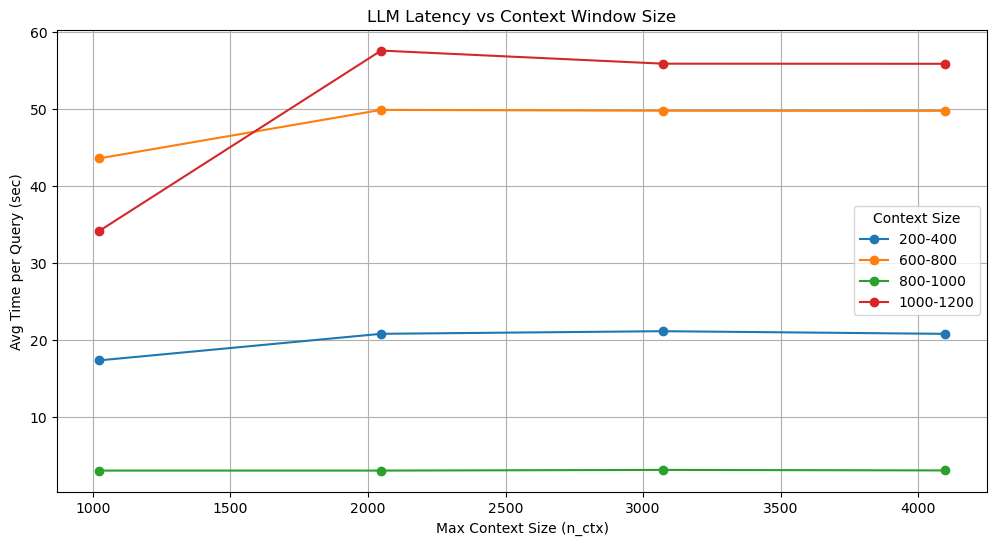

In [16]:
print(results)
plt.figure(figsize=(12, 6))
for group in query_groups.keys():
    group_data = df_results[df_results["query_length_group"] == group]
    plt.plot(group_data["n_ctx"], group_data["avg_time_per_query"], marker='o', label=group)

plt.title("LLM Latency vs Context Window Size")
plt.xlabel("Max Context Size (n_ctx)")
plt.ylabel("Avg Time per Query (sec)")
plt.legend(title="Context Size")
plt.grid(True)

plt.show()